In [1]:
import os
import sys
sys.path.insert(0, '..')

import argparse
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from utils import *
from model.metric import evaluate, acc, LSR
from model.data import DAdataset
from model.net import LSTMClassifier
from model.utils import sent_tokenize, stemming, preprocess_text
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter



In [2]:
home_dir = Path('..')
data_dir = home_dir / 'dataset' / 'SDAC'
save_dir = home_dir / 'experiment' / 'SDAC'
train_data_name = 'sw_train.txt'
valid_data_name = 'sw_val.txt'
test_data_name = 'sw_test.txt'
# pretrained_embeddings_name = 'embeddings.pkl'
token2idx_name = 'word2idx.json'
label2idx_name = 'label2idx.json'
config_name = 'config.json'
    
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)

In [3]:
args = {
    "epochs": 100,
    "n_batch": 64,
    "max_len": 256,
    "lr": 1e-5,
    "summary_step": 10000,
    "embedding_dim": 128,
    "hidden_size": 256,
    "n_layers": 1,
}
args = argparse.Namespace(**args)
print(args)

Namespace(embedding_dim=128, epochs=100, hidden_size=256, lr=1e-05, max_len=256, n_batch=64, n_layers=1, summary_step=10000)


In [4]:
# with open(data_dir / pretrained_embeddings_name, 'rb') as f:
#     pretrained_embeddings = pickle.load(f)
    
with open(data_dir / token2idx_name, 'r') as f:
    token2idx = json.load(f)
    
with open(data_dir / label2idx_name, 'r') as f:
    label2idx = json.load(f)
    
with open(data_dir / config_name, 'r') as f:
    config = json.load(f)
    
idx2token = {i:t for t,i in token2idx.items()}
idx2label = {i:l for l,i in label2idx.items()}

## Train

In [5]:
# 데이터 전처리 

train_data = pd.read_csv(data_dir / train_data_name, header=None, sep='|', names=['speaker','utterance','tag'])
valid_data = pd.read_csv(data_dir / valid_data_name, header=None, sep='|', names=['speaker','utterance','tag'])


x_train, y_train = train_data['utterance'], train_data['tag']
x_valid, y_valid = valid_data['utterance'], valid_data['tag']

text_preprocess_pipeline = [sent_tokenize, stemming] # 이전에 해줬던 전처리 과정과 동일하게 해줘야 함

x_train = x_train.apply(preprocess_text, processing_function_list=text_preprocess_pipeline)
x_valid = x_valid.apply(preprocess_text, processing_function_list=text_preprocess_pipeline)

In [6]:
# 학습 데이터 구성

x_train = list(convert_token_to_idx(x_train, token2idx))
x_valid = list(convert_token_to_idx(x_valid, token2idx))

y_train = list(convert_label_to_idx(y_train, label2idx))
y_valid = list(convert_label_to_idx(y_valid, label2idx))

tr_ds = DAdataset(x_train, y_train)
tr_dl = DataLoader(tr_ds, batch_size=args.n_batch, collate_fn=tr_ds.collate_fn, shuffle=True, drop_last=True)

val_ds = DAdataset(x_valid, y_valid)
val_dl = DataLoader(val_ds, batch_size=args.n_batch, collate_fn=val_ds.collate_fn, shuffle=True, drop_last=True)

In [7]:
# 모델 생성

learning_rate = args.lr
batch_size = args.n_batch
vocab_size = len(token2idx)
embedding_dim = args.embedding_dim
hidden_size = args.hidden_size
output_size = len(label2idx)
n_layers = args.n_layers
dropout = 0.7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(batch_size, output_size, hidden_size, vocab_size, n_layers, embedding_dim, device,
                       dropout=dropout, bidirectional=True) #, weights=torch.from_numpy(pretrained_embeddings))

loss_fn = LSR(epsilon=0.1, num_classes=output_size)

if device.type == 'cuda':
    torch.cuda.empty_cache()

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)

writer = SummaryWriter(f'{save_dir}/runs')
checkpoint_manager = CheckpointManager(save_dir)
summary_manager = SummaryManager(save_dir)

In [8]:
# 모델 학습

best_val_loss = 1e+10
train_acc = []
valid_acc = []
train_losses = []
valid_losses = []
x_error_check = []  # Issue 에 대한 디버깅 코드

for epoch in tqdm(range(args.epochs), desc='epochs'):
    tr_loss = 0
    tr_acc = 0
    model.train()
    
    for step, mb in tqdm(enumerate(tr_dl), desc='steps', total=len(tr_dl)):
        x_mb, y_mb = map(lambda elm: elm.to(device), mb)
        
        x_error_check.append(x_mb)
        if len(x_error_check) > 2:
            del x_error_check[0]
        
        optimizer.zero_grad()
        y_hat_mb = model(x_mb)
        loss = loss_fn(y_hat_mb, y_mb)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            mb_acc = acc(y_hat_mb, y_mb)
        
        clip_gradient(model, 1e-1)
        
        tr_loss += loss.item()
        tr_acc += mb_acc.item()
        
        if (epoch*len(tr_dl)+step) % args.summary_step == 0:
            val_loss = evaluate(model, val_dl, {'loss':loss_fn}, device)['loss']
            writer.add_scalars('loss', {'train': tr_loss / (step + 1), 'val': val_loss}, epoch*len(tr_dl) + step)
            tqdm.write('global_Step: {:3}, tr_loss: {:3f}, val_loss: {:3f}'.format(epoch* len(tr_dl) + step,
                                                                                       tr_loss / (step + 1),
                                                                                       val_loss))
            model.train()
    
    else:
        tr_loss  /= (step + 1)
        tr_acc /= (step + 1)
        train_losses.append(tr_loss)
        train_acc.append(tr_acc)
        
        tr_sum = {'loss': tr_loss, 'acc': tr_acc}
        val_sum = evaluate(model, val_dl, {'loss': loss_fn, 'acc': acc}, device)
        tqdm.write('epoch : {}, tr_loss: {: 3f}, val_loss: '
                       '{:.3f}, tr_acc: {:.2%}, val_acc: {:.2%}'.format(epoch+1, tr_sum['loss'], val_sum['loss'],
                                                                        tr_sum['acc'], val_sum['acc']))
        
        val_loss = val_sum['loss']
        valid_losses.append(val_loss)
        valid_acc.append(val_sum['acc'])
        is_best = val_loss < best_val_loss
        
        if is_best:
            state = {
                'epoch': epoch+1, 
                'model_state_dict': model.state_dict(), 
                'opt_state_dict': optimizer.state_dict()
            }
            summary = {'tr': tr_sum, 'val': val_sum}
            summary_manager.update(summary)
            summary_manager.save('summary.json')
            checkpoint_manager.save_checkpoint(state, 'best.tar')
            best_val_loss = val_loss

steps: 100%|██████████| 51/51 [00:00<00:00, 267.02it/s]


global_Step:   0, tr_loss: 1.251260, val_loss: 1.245575


steps: 100%|██████████| 51/51 [00:00<00:00, 272.73it/s]


epoch : 1, tr_loss:  0.845485, val_loss: 0.627, tr_acc: 49.17%, val_acc: 55.81%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 2, tr_loss:  0.645175, val_loss: 0.564, tr_acc: 58.74%, val_acc: 60.79%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.27it/s]


epoch : 3, tr_loss:  0.603956, val_loss: 0.536, tr_acc: 61.57%, val_acc: 63.57%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.33it/s]


global_Step: 10000, tr_loss: 0.587189, val_loss: 0.531891


steps: 100%|██████████| 51/51 [00:00<00:00, 270.51it/s]


epoch : 4, tr_loss:  0.581376, val_loss: 0.520, tr_acc: 63.18%, val_acc: 65.07%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.85it/s]


epoch : 5, tr_loss:  0.565405, val_loss: 0.509, tr_acc: 64.42%, val_acc: 66.29%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.73it/s]


epoch : 6, tr_loss:  0.553915, val_loss: 0.497, tr_acc: 65.28%, val_acc: 67.88%


steps: 100%|██████████| 51/51 [00:00<00:00, 279.44it/s]


global_Step: 20000, tr_loss: 0.547872, val_loss: 0.492849


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 7, tr_loss:  0.544648, val_loss: 0.493, tr_acc: 65.98%, val_acc: 67.70%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 8, tr_loss:  0.535221, val_loss: 0.484, tr_acc: 66.65%, val_acc: 68.80%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.74it/s]


epoch : 9, tr_loss:  0.527965, val_loss: 0.478, tr_acc: 67.22%, val_acc: 69.28%


steps: 100%|██████████| 51/51 [00:00<00:00, 279.47it/s]


global_Step: 30000, tr_loss: 0.520653, val_loss: 0.476370


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 10, tr_loss:  0.520740, val_loss: 0.474, tr_acc: 67.69%, val_acc: 69.74%


steps:  53%|█████▎    | 27/51 [00:00<00:00, 265.05it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 260.38it/s]

epoch : 11, tr_loss:  0.515563, val_loss: 0.465, tr_acc: 68.20%, val_acc: 70.60%


steps: 100%|██████████| 51/51 [00:00<00:00, 263.69it/s]


epoch : 12, tr_loss:  0.511076, val_loss: 0.461, tr_acc: 68.48%, val_acc: 70.84%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.72it/s]


epoch : 13, tr_loss:  0.506296, val_loss: 0.464, tr_acc: 68.71%, val_acc: 70.75%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.20it/s]


global_Step: 40000, tr_loss: 0.505174, val_loss: 0.456833


steps:  47%|████▋     | 24/51 [00:00<00:00, 240.00it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 244.02it/s]

epoch : 14, tr_loss:  0.501779, val_loss: 0.453, tr_acc: 68.96%, val_acc: 71.45%


steps:  51%|█████     | 26/51 [00:00<00:00, 252.43it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 250.00it/s]

epoch : 15, tr_loss:  0.499004, val_loss: 0.451, tr_acc: 69.32%, val_acc: 71.30%


steps: 100%|██████████| 51/51 [00:00<00:00, 266.08it/s]


epoch : 16, tr_loss:  0.495388, val_loss: 0.447, tr_acc: 69.46%, val_acc: 72.04%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.96it/s]


global_Step: 50000, tr_loss: 0.494968, val_loss: 0.450629


steps: 100%|██████████| 51/51 [00:00<00:00, 256.12it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 253.73it/s]

epoch : 17, tr_loss:  0.492305, val_loss: 0.449, tr_acc: 69.69%, val_acc: 71.55%


steps: 100%|██████████| 51/51 [00:00<00:00, 261.53it/s]


epoch : 18, tr_loss:  0.490041, val_loss: 0.447, tr_acc: 69.87%, val_acc: 71.39%


steps:  51%|█████     | 26/51 [00:00<00:00, 251.77it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 257.23it/s]

epoch : 19, tr_loss:  0.486936, val_loss: 0.440, tr_acc: 69.98%, val_acc: 71.94%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.28it/s]


global_Step: 60000, tr_loss: 0.483979, val_loss: 0.441871


steps: 100%|██████████| 51/51 [00:00<00:00, 272.73it/s]


epoch : 20, tr_loss:  0.483976, val_loss: 0.441, tr_acc: 70.21%, val_acc: 72.00%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.28it/s]


epoch : 21, tr_loss:  0.482312, val_loss: 0.441, tr_acc: 70.33%, val_acc: 72.28%


steps: 100%|██████████| 51/51 [00:00<00:00, 261.54it/s]


epoch : 22, tr_loss:  0.479770, val_loss: 0.438, tr_acc: 70.45%, val_acc: 72.13%


steps: 100%|██████████| 51/51 [00:00<00:00, 253.73it/s]


epoch : 23, tr_loss:  0.477956, val_loss: 0.437, tr_acc: 70.65%, val_acc: 72.37%


steps: 100%|██████████| 51/51 [00:00<00:00, 265.63it/s]


global_Step: 70000, tr_loss: 0.475251, val_loss: 0.437814


steps: 100%|██████████| 51/51 [00:00<00:00, 274.19it/s]


epoch : 24, tr_loss:  0.475995, val_loss: 0.431, tr_acc: 70.78%, val_acc: 72.74%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.33it/s]


epoch : 25, tr_loss:  0.474453, val_loss: 0.434, tr_acc: 70.82%, val_acc: 72.43%


steps: 100%|██████████| 51/51 [00:00<00:00, 255.85it/s]


epoch : 26, tr_loss:  0.472159, val_loss: 0.431, tr_acc: 70.95%, val_acc: 72.65%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.19it/s]


global_Step: 80000, tr_loss: 0.470440, val_loss: 0.432652


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 27, tr_loss:  0.471245, val_loss: 0.429, tr_acc: 70.96%, val_acc: 72.74%


steps: 100%|██████████| 51/51 [00:00<00:00, 276.34it/s]


epoch : 28, tr_loss:  0.469464, val_loss: 0.428, tr_acc: 71.20%, val_acc: 72.95%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.00it/s]


epoch : 29, tr_loss:  0.467916, val_loss: 0.427, tr_acc: 71.21%, val_acc: 73.04%


steps: 100%|██████████| 51/51 [00:00<00:00, 285.53it/s]


global_Step: 90000, tr_loss: 0.466108, val_loss: 0.424271


steps: 100%|██████████| 51/51 [00:00<00:00, 264.72it/s]


epoch : 30, tr_loss:  0.465707, val_loss: 0.428, tr_acc: 71.37%, val_acc: 72.86%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.89it/s]


epoch : 31, tr_loss:  0.464824, val_loss: 0.424, tr_acc: 71.45%, val_acc: 73.20%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.28it/s]


epoch : 32, tr_loss:  0.463254, val_loss: 0.423, tr_acc: 71.57%, val_acc: 73.04%


steps: 100%|██████████| 51/51 [00:00<00:00, 262.88it/s]


epoch : 33, tr_loss:  0.462791, val_loss: 0.425, tr_acc: 71.56%, val_acc: 72.95%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.33it/s]


global_Step: 100000, tr_loss: 0.459594, val_loss: 0.421759


steps: 100%|██████████| 51/51 [00:00<00:00, 272.43it/s]


epoch : 34, tr_loss:  0.460770, val_loss: 0.422, tr_acc: 71.67%, val_acc: 73.32%


steps: 100%|██████████| 51/51 [00:00<00:00, 267.01it/s]


epoch : 35, tr_loss:  0.459997, val_loss: 0.422, tr_acc: 71.77%, val_acc: 73.11%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 36, tr_loss:  0.458828, val_loss: 0.422, tr_acc: 71.78%, val_acc: 73.38%


steps: 100%|██████████| 51/51 [00:00<00:00, 277.27it/s]


global_Step: 110000, tr_loss: 0.458500, val_loss: 0.422748


steps: 100%|██████████| 51/51 [00:00<00:00, 271.28it/s]


epoch : 37, tr_loss:  0.457535, val_loss: 0.419, tr_acc: 71.88%, val_acc: 73.62%


steps: 100%|██████████| 51/51 [00:00<00:00, 261.54it/s]


epoch : 38, tr_loss:  0.455873, val_loss: 0.424, tr_acc: 72.00%, val_acc: 73.14%


steps: 100%|██████████| 51/51 [00:00<00:00, 267.95it/s]


epoch : 39, tr_loss:  0.455381, val_loss: 0.417, tr_acc: 72.07%, val_acc: 73.75%


steps: 100%|██████████| 51/51 [00:00<00:00, 278.69it/s]


global_Step: 120000, tr_loss: 0.454749, val_loss: 0.420750


steps: 100%|██████████| 51/51 [00:00<00:00, 268.02it/s]


epoch : 40, tr_loss:  0.454877, val_loss: 0.416, tr_acc: 72.06%, val_acc: 73.78%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 41, tr_loss:  0.453130, val_loss: 0.420, tr_acc: 72.15%, val_acc: 73.47%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.45it/s]


epoch : 42, tr_loss:  0.452500, val_loss: 0.419, tr_acc: 72.21%, val_acc: 73.44%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.67it/s]


epoch : 43, tr_loss:  0.450860, val_loss: 0.416, tr_acc: 72.35%, val_acc: 73.96%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.70it/s]


global_Step: 130000, tr_loss: 0.449879, val_loss: 0.419562


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 44, tr_loss:  0.450802, val_loss: 0.420, tr_acc: 72.43%, val_acc: 73.50%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.28it/s]


epoch : 45, tr_loss:  0.449871, val_loss: 0.416, tr_acc: 72.47%, val_acc: 73.78%


steps: 100%|██████████| 51/51 [00:00<00:00, 264.61it/s]


epoch : 46, tr_loss:  0.448681, val_loss: 0.411, tr_acc: 72.51%, val_acc: 73.96%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.77it/s]


global_Step: 140000, tr_loss: 0.445429, val_loss: 0.418070


steps: 100%|██████████| 51/51 [00:00<00:00, 266.94it/s]


epoch : 47, tr_loss:  0.448110, val_loss: 0.418, tr_acc: 72.46%, val_acc: 73.69%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 48, tr_loss:  0.447818, val_loss: 0.417, tr_acc: 72.52%, val_acc: 73.53%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.96it/s]


epoch : 49, tr_loss:  0.446536, val_loss: 0.419, tr_acc: 72.64%, val_acc: 73.56%


steps: 100%|██████████| 51/51 [00:00<00:00, 265.59it/s]


global_Step: 150000, tr_loss: 0.445172, val_loss: 0.412295


steps:  51%|█████     | 26/51 [00:00<00:00, 254.64it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 258.60it/s]

epoch : 50, tr_loss:  0.445520, val_loss: 0.416, tr_acc: 72.72%, val_acc: 73.87%


steps: 100%|██████████| 51/51 [00:00<00:00, 252.48it/s]


epoch : 51, tr_loss:  0.444722, val_loss: 0.417, tr_acc: 72.74%, val_acc: 73.75%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.01it/s]


epoch : 52, tr_loss:  0.443988, val_loss: 0.413, tr_acc: 72.80%, val_acc: 73.93%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.01it/s]


epoch : 53, tr_loss:  0.442820, val_loss: 0.410, tr_acc: 72.84%, val_acc: 74.45%


steps: 100%|██████████| 51/51 [00:00<00:00, 280.60it/s]


global_Step: 160000, tr_loss: 0.443142, val_loss: 0.413082


steps: 100%|██████████| 51/51 [00:00<00:00, 271.98it/s]


epoch : 54, tr_loss:  0.442332, val_loss: 0.416, tr_acc: 72.91%, val_acc: 74.08%


steps: 100%|██████████| 51/51 [00:00<00:00, 266.71it/s]


epoch : 55, tr_loss:  0.441477, val_loss: 0.411, tr_acc: 72.92%, val_acc: 74.48%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 56, tr_loss:  0.440925, val_loss: 0.410, tr_acc: 72.97%, val_acc: 74.60%


steps: 100%|██████████| 51/51 [00:00<00:00, 282.10it/s]


global_Step: 170000, tr_loss: 0.439179, val_loss: 0.409589


steps: 100%|██████████| 51/51 [00:00<00:00, 271.27it/s]


epoch : 57, tr_loss:  0.440141, val_loss: 0.408, tr_acc: 73.02%, val_acc: 74.85%


steps: 100%|██████████| 51/51 [00:00<00:00, 253.73it/s]


epoch : 58, tr_loss:  0.439681, val_loss: 0.415, tr_acc: 73.13%, val_acc: 74.11%


steps: 100%|██████████| 51/51 [00:00<00:00, 266.31it/s]


epoch : 59, tr_loss:  0.438891, val_loss: 0.417, tr_acc: 73.11%, val_acc: 73.99%


steps: 100%|██████████| 51/51 [00:00<00:00, 266.56it/s]


global_Step: 180000, tr_loss: 0.437767, val_loss: 0.407125


steps: 100%|██████████| 51/51 [00:00<00:00, 253.73it/s]


epoch : 60, tr_loss:  0.438110, val_loss: 0.411, tr_acc: 73.16%, val_acc: 74.17%


steps: 100%|██████████| 51/51 [00:00<00:00, 257.57it/s]


epoch : 61, tr_loss:  0.437643, val_loss: 0.409, tr_acc: 73.17%, val_acc: 74.66%


steps: 100%|██████████| 51/51 [00:00<00:00, 262.89it/s]


epoch : 62, tr_loss:  0.436661, val_loss: 0.408, tr_acc: 73.35%, val_acc: 75.06%


steps:  98%|█████████▊| 50/51 [00:00<00:00, 242.30it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 241.42it/s]

epoch : 63, tr_loss:  0.436035, val_loss: 0.408, tr_acc: 73.29%, val_acc: 74.51%


steps: 100%|██████████| 51/51 [00:00<00:00, 278.69it/s]


global_Step: 190000, tr_loss: 0.432697, val_loss: 0.409020


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 64, tr_loss:  0.435180, val_loss: 0.416, tr_acc: 73.36%, val_acc: 74.08%


steps: 100%|██████████| 51/51 [00:00<00:00, 264.25it/s]


epoch : 65, tr_loss:  0.434378, val_loss: 0.408, tr_acc: 73.46%, val_acc: 74.42%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.83it/s]


epoch : 66, tr_loss:  0.434088, val_loss: 0.414, tr_acc: 73.50%, val_acc: 74.27%


steps: 100%|██████████| 51/51 [00:00<00:00, 280.22it/s]


global_Step: 200000, tr_loss: 0.432967, val_loss: 0.409055


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 67, tr_loss:  0.433922, val_loss: 0.407, tr_acc: 73.48%, val_acc: 75.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 68, tr_loss:  0.432997, val_loss: 0.413, tr_acc: 73.49%, val_acc: 74.51%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.08it/s]


epoch : 69, tr_loss:  0.432370, val_loss: 0.409, tr_acc: 73.57%, val_acc: 74.66%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.77it/s]


global_Step: 210000, tr_loss: 0.431859, val_loss: 0.408217


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 70, tr_loss:  0.432362, val_loss: 0.411, tr_acc: 73.59%, val_acc: 74.21%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.04it/s]


epoch : 71, tr_loss:  0.431385, val_loss: 0.410, tr_acc: 73.62%, val_acc: 74.88%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 72, tr_loss:  0.430889, val_loss: 0.403, tr_acc: 73.57%, val_acc: 75.34%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.20it/s]


epoch : 73, tr_loss:  0.430531, val_loss: 0.409, tr_acc: 73.61%, val_acc: 74.82%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.38it/s]


global_Step: 220000, tr_loss: 0.431978, val_loss: 0.407080


steps: 100%|██████████| 51/51 [00:00<00:00, 271.27it/s]


epoch : 74, tr_loss:  0.429839, val_loss: 0.408, tr_acc: 73.72%, val_acc: 74.72%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.72it/s]


epoch : 75, tr_loss:  0.429166, val_loss: 0.410, tr_acc: 73.72%, val_acc: 75.06%


steps: 100%|██████████| 51/51 [00:00<00:00, 262.89it/s]


epoch : 76, tr_loss:  0.428584, val_loss: 0.405, tr_acc: 73.84%, val_acc: 75.00%


steps: 100%|██████████| 51/51 [00:00<00:00, 278.68it/s]


global_Step: 230000, tr_loss: 0.427909, val_loss: 0.405372


steps: 100%|██████████| 51/51 [00:00<00:00, 272.72it/s]


epoch : 77, tr_loss:  0.428199, val_loss: 0.411, tr_acc: 73.78%, val_acc: 74.76%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.03it/s]


epoch : 78, tr_loss:  0.427677, val_loss: 0.409, tr_acc: 73.91%, val_acc: 75.06%


steps:  98%|█████████▊| 50/51 [00:00<00:00, 248.51it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 245.19it/s]

epoch : 79, tr_loss:  0.427006, val_loss: 0.406, tr_acc: 73.85%, val_acc: 75.00%


steps: 100%|██████████| 51/51 [00:00<00:00, 278.49it/s]


global_Step: 240000, tr_loss: 0.425911, val_loss: 0.418649


steps: 100%|██████████| 51/51 [00:00<00:00, 266.98it/s]


epoch : 80, tr_loss:  0.425651, val_loss: 0.410, tr_acc: 73.99%, val_acc: 74.85%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.73it/s]


epoch : 81, tr_loss:  0.425770, val_loss: 0.404, tr_acc: 73.94%, val_acc: 75.58%


steps: 100%|██████████| 51/51 [00:00<00:00, 267.24it/s]


epoch : 82, tr_loss:  0.425320, val_loss: 0.406, tr_acc: 74.03%, val_acc: 75.28%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 83, tr_loss:  0.424646, val_loss: 0.412, tr_acc: 74.07%, val_acc: 74.88%


steps: 100%|██████████| 51/51 [00:00<00:00, 279.25it/s]


global_Step: 250000, tr_loss: 0.428974, val_loss: 0.404097


steps: 100%|██████████| 51/51 [00:00<00:00, 271.27it/s]


epoch : 84, tr_loss:  0.424189, val_loss: 0.412, tr_acc: 74.07%, val_acc: 74.79%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 85, tr_loss:  0.423554, val_loss: 0.410, tr_acc: 74.12%, val_acc: 75.03%


steps: 100%|██████████| 51/51 [00:00<00:00, 267.72it/s]


epoch : 86, tr_loss:  0.423316, val_loss: 0.406, tr_acc: 74.14%, val_acc: 75.64%


steps: 100%|██████████| 51/51 [00:00<00:00, 282.86it/s]


global_Step: 260000, tr_loss: 0.423181, val_loss: 0.406213


steps: 100%|██████████| 51/51 [00:00<00:00, 262.88it/s]


epoch : 87, tr_loss:  0.422855, val_loss: 0.406, tr_acc: 74.14%, val_acc: 75.40%


steps: 100%|██████████| 51/51 [00:00<00:00, 263.76it/s]


epoch : 88, tr_loss:  0.421846, val_loss: 0.405, tr_acc: 74.23%, val_acc: 75.09%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.40it/s]


epoch : 89, tr_loss:  0.422036, val_loss: 0.408, tr_acc: 74.25%, val_acc: 75.00%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.53it/s]


global_Step: 270000, tr_loss: 0.421153, val_loss: 0.411863


steps: 100%|██████████| 51/51 [00:00<00:00, 263.10it/s]


epoch : 90, tr_loss:  0.421175, val_loss: 0.407, tr_acc: 74.28%, val_acc: 75.37%


steps:  98%|█████████▊| 50/51 [00:00<00:00, 243.64it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 242.05it/s]

epoch : 91, tr_loss:  0.421160, val_loss: 0.416, tr_acc: 74.29%, val_acc: 74.66%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.64it/s]


epoch : 92, tr_loss:  0.420520, val_loss: 0.412, tr_acc: 74.40%, val_acc: 74.97%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 93, tr_loss:  0.419648, val_loss: 0.410, tr_acc: 74.34%, val_acc: 74.88%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.80it/s]


global_Step: 280000, tr_loss: 0.414790, val_loss: 0.406383


steps:  51%|█████     | 26/51 [00:00<00:00, 260.00it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 260.21it/s]

epoch : 94, tr_loss:  0.419466, val_loss: 0.412, tr_acc: 74.39%, val_acc: 75.18%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.43it/s]


epoch : 95, tr_loss:  0.418956, val_loss: 0.416, tr_acc: 74.37%, val_acc: 74.63%


steps: 100%|██████████| 51/51 [00:00<00:00, 267.01it/s]


epoch : 96, tr_loss:  0.418239, val_loss: 0.412, tr_acc: 74.51%, val_acc: 75.12%


steps: 100%|██████████| 51/51 [00:00<00:00, 277.60it/s]


global_Step: 290000, tr_loss: 0.416735, val_loss: 0.409755


steps: 100%|██████████| 51/51 [00:00<00:00, 271.28it/s]


epoch : 97, tr_loss:  0.417715, val_loss: 0.404, tr_acc: 74.59%, val_acc: 75.61%


steps: 100%|██████████| 51/51 [00:00<00:00, 264.91it/s]


epoch : 98, tr_loss:  0.417300, val_loss: 0.413, tr_acc: 74.50%, val_acc: 75.34%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 99, tr_loss:  0.417595, val_loss: 0.406, tr_acc: 74.50%, val_acc: 75.12%


steps: 100%|██████████| 51/51 [00:00<00:00, 279.28it/s]


global_Step: 300000, tr_loss: 0.416247, val_loss: 0.404925


steps: 100%|██████████| 51/51 [00:00<00:00, 261.27it/s]


epoch : 100, tr_loss:  0.416243, val_loss: 0.415, tr_acc: 74.54%, val_acc: 75.24%



    1. jupyter notebook 버전이 다르면 tqdm이 안예쁘게 나올 수 있음
    2. gpu를 안쓸경우 생각보다 오래 걸림

    Issue) 갑자기 아래의 에러가 나는 경우
    
    (Expected tensor for argument #1 'indices' to have scalar type Long; but got torch.cuda.FloatTensor instead 
     while checking arguments for embedding)
    
    tr_dl 에서 나오는 index가 갑자기 소수점으로 바뀌는 경우가 있음. 
    위 에러가 뜬 뒤, x_mb.dtype 을 확인해보면 데이터 타입이 torch.float32 로 바뀌어 있음.
    아마, batch 의 첫 번째 row가 empty일때, 이를 빼고 배치를 계산한뒤 다시 복구시킬때 gpu 에서 소수점으로 반환하는듯 
    (torch gpu 초기값 문제일수도 있음)
    
    해결) 데이터 전처리시, punctuation 을 제거하지 않음. 문장중에 . 혹은 ? 만 있는 문장이 있기 때문에 empty sentence가 생김

In [9]:
summary

{'tr': {'loss': 0.43088937616713113, 'acc': 0.7356744843646041},
 'val': {'loss': 0.4025312385232641, 'acc': 0.753361858190709}}

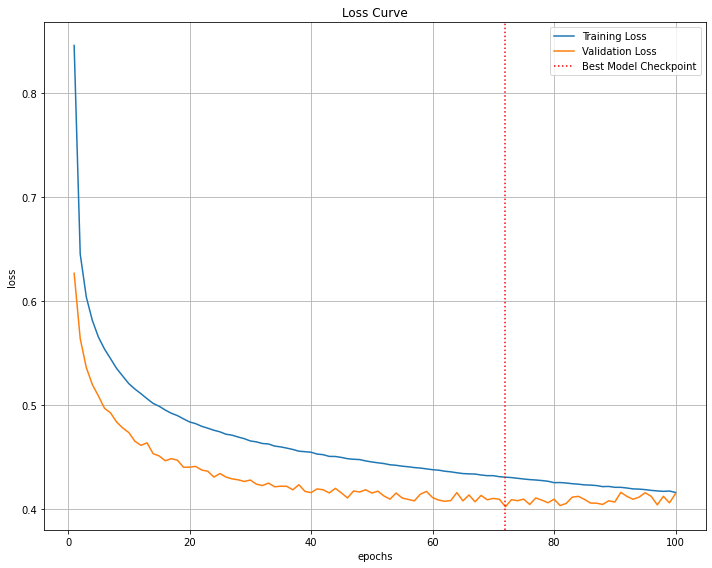

In [10]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses)+1), valid_losses, label='Validation Loss')

minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs, linestyle='dotted', color='r',label='Best Model Checkpoint')

plt.title('Loss Curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/loss_plot.png', bbox_inches = 'tight')

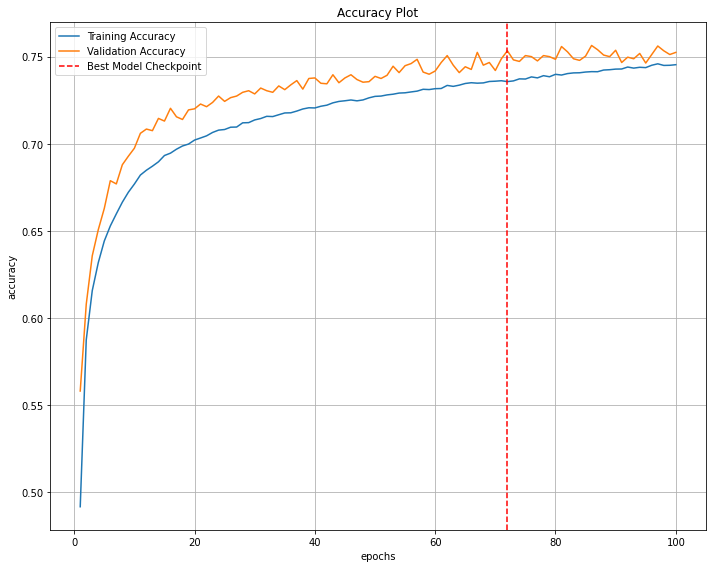

In [11]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc)+1), train_acc, label='Training Accuracy')
plt.plot(range(1,len(valid_acc)+1), valid_acc, label='Validation Accuracy')

minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs, linestyle='--', color='r',label='Best Model Checkpoint')

plt.title('Accuracy Plot')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/accuracy_plot.png', bbox_inches = 'tight')

### Test Label 이 존재할 경우

In [12]:
test_data = pd.read_csv(data_dir / test_data_name, header=None, sep='|', names=['speaker','utterance','tag'])

x_test, y_test = test_data['utterance'], test_data['tag']

text_preprocess_pipeline = [sent_tokenize, stemming]
x_test = x_test.apply(preprocess_text, processing_function_list=text_preprocess_pipeline)

x_test = list(convert_token_to_idx(x_test, token2idx))
y_test = list(convert_label_to_idx(y_test, label2idx))

test_ds = DAdataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=64, collate_fn=test_ds.collate_fn, drop_last=True)

In [13]:
summ = evaluate(model, test_dl, {'loss': loss_fn, 'acc': acc}, device)

summary_manager = SummaryManager(save_dir)
summary_manager.load('summary.json')
summary_manager.update(summ)
summary_manager.save('summary.json')

print('loss: {:3f}, acc: {:.2%}'.format(summ['loss'], summ['acc']))

steps: 100%|██████████| 63/63 [00:00<00:00, 257.90it/s]

loss: 0.445932, acc: 70.65%


https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222
https://quokkas.tistory.com/entry/pytorch%EC%97%90%EC%84%9C-EarlyStop-%EC%9D%B4%EC%9A%A9%ED%95%98%EA%B8%B0
https://simonjisu.github.io/nlp/2018/07/05/packedsequence.html
https://nbviewer.jupyter.org/github/simonjisu/pytorch_tutorials/blob/master/00_Basic_Utils/02_PackedSequence.ipynb

데이터 전처리: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=qbxlvnf11&logNo=221434157182

pretrained 사용: https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222